In [4]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import re
import os
import math

In [2]:
child_w1_df = pd.read_csv('1_EXP05_Full/week_1/child.csv').iloc[: , 1:]
child_w4_df = pd.read_csv('1_EXP05_Full/week_4/child.csv').iloc[: , 1:]

## Markov Chain

In [4]:
# outside = outside pre-defined boxes
# nodetection = openCV cannot find eyes
# screen, robot, parent

def transition_matrix(transitions, order=-1):
    df = pd.DataFrame(transitions)
    
    # create a new column with data shifted one space
    df['shift'] = df[0].shift(order)

    # add a count column (for group by function)
    df['count'] = 1

    # groupby and then unstack, fill the zeros
    trans_mat = df.groupby([0, 'shift']).count().unstack().fillna(0)

    # normalise by occurences and save values to get transition matrix
    trans_mat = trans_mat.div(trans_mat.sum(axis=1), axis=0).values
    labels = np.unique(transitions)
    
    return trans_mat, labels

In [5]:
transitions_w1 = np.asarray(child_w1_df[child_w1_df['object'] != 'nodetection']['object'])
transitions_w4 = np.asarray(child_w4_df[child_w4_df['object'] != 'nodetection']['object'])

trans_mat_w1, labels_w1 = transition_matrix(transitions_w1, order=-1)
trans_mat_w4, labels_w4 = transition_matrix(transitions_w4, order=-1)

In [6]:
# x-axis = next state
# y-axis = current state

print(trans_mat_w1, labels_w1)
print(trans_mat_w4, labels_w4)

[[0.33606557 0.00409836 0.04918033 0.61065574]
 [0.66666667 0.33333333 0.         0.        ]
 [0.2027027  0.         0.18918919 0.60810811]
 [0.34688995 0.00239234 0.11483254 0.53588517]] ['outside' 'parent' 'robot' 'screen']
[[0.2        0.00656934 0.06642336 0.7270073 ]
 [0.15384615 0.17948718 0.38461538 0.28205128]
 [0.15445026 0.02225131 0.19895288 0.62434555]
 [0.33586469 0.00207111 0.17466344 0.48740076]] ['outside' 'parent' 'robot' 'screen']


In [7]:
def KL(P,Q):
     epsilon = 0.00001
     P = P+epsilon
     Q = Q+epsilon

     divergence = np.sum(P*np.log(P/Q))
     return divergence

print('\nKL(week 1 || week 4): ')
for i in range(0, len(trans_mat_w1)):
    print(labels_w1[i], KL(trans_mat_w1[i], trans_mat_w4[i]))

print('\nKL(week 4 || week 1): ')
for i in range(0, len(trans_mat_w1)):
    print(labels_w4[i], KL(trans_mat_w4[i], trans_mat_w1[i]))


KL(week 1 || week 4): 
outside 0.05119579032370833
parent 1.1836753512630664
robot 0.02948639608143425
screen 0.01420883668398295

KL(week 4 || week 1): 
outside 0.04605493955574122
parent 6.614315999567413
robot 0.15606386867094638
screen 0.01588168023953932


## ANOVA on Gaze

In [3]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})

### Data Processing

In [4]:
PID = '1_EXP05_Full/'

In [5]:
# read data
df_c_w1 = pd.read_csv(PID + 'week_1/' + 'child.csv')
df_c_w2 = pd.read_csv(PID + 'week_2/' + 'child.csv')
df_c_w3 = pd.read_csv(PID + 'week_3/' + 'child.csv')
df_c_w4 = pd.read_csv(PID + 'week_4/' + 'child.csv')

In [6]:
# remove rows where the duration is 0
df_c_w1 = df_c_w1[df_c_w1['duration'] != 0]
df_c_w2 = df_c_w2[df_c_w2['duration'] != 0]
df_c_w3 = df_c_w3[df_c_w3['duration'] != 0]
df_c_w4 = df_c_w4[df_c_w4['duration'] != 0]

In [7]:
# remove outliers
df_c_w1 = df_c_w1[(np.abs(stats.zscore(df_c_w1['duration'])) < 3)].reset_index()
df_c_w2 = df_c_w2[(np.abs(stats.zscore(df_c_w2['duration'])) < 3)].reset_index()
df_c_w3 = df_c_w3[(np.abs(stats.zscore(df_c_w3['duration'])) < 3)].reset_index()
df_c_w4 = df_c_w4[(np.abs(stats.zscore(df_c_w4['duration'])) < 3)].reset_index()

In [11]:
# determine unique days in dataset
_, unique_days_w1 = get_unique_days(df_c_w1['start'])
_, unique_days_w2 = get_unique_days(df_c_w2['start'])
_, unique_days_w3 = get_unique_days(df_c_w3['start'])
_, unique_days_w4 = get_unique_days(df_c_w4['start'])

unique_days = np.concatenate((unique_days_w1, unique_days_w2, unique_days_w3, unique_days_w4), axis = 0)
print(unique_days)

[ 7 10 11 14 16 17 18 20 21 22 23 25 27 28  2  3  4  5  6  7  8 29 30 31]


In [12]:
# set day (of study) identifier
df_c_w1['day'] = df_c_w1['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day))
df_c_w2['day'] = df_c_w2['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)))
df_c_w3['day'] = df_c_w3['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)))
df_c_w4['day'] = df_c_w4['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)+len(unique_days_w3)))

In [13]:
# set week identifier
df_c_w1['week'] = 1
df_c_w2['week'] = 2
df_c_w3['week'] = 3
df_c_w4['week'] = 4

In [14]:
# apply data transform
df_c_w1['log_duration'] = df_c_w1['duration'].apply(lambda x: math.log(x))
df_c_w2['log_duration'] = df_c_w2['duration'].apply(lambda x: math.log(x))
df_c_w3['log_duration'] = df_c_w3['duration'].apply(lambda x: math.log(x))
df_c_w4['log_duration'] = df_c_w4['duration'].apply(lambda x: math.log(x))

In [17]:
# remove index
df_c_w1 = df_c_w1.iloc[:, 1:]
df_c_w2 = df_c_w2.iloc[:, 1:]
df_c_w3 = df_c_w3.iloc[:, 1:]
df_c_w4 = df_c_w4.iloc[:, 1:]

In [18]:
# check table formatting
df_c_w1

,object,duration,start,day,week,log_duration
0,nodetection,14.193398,1.499458e+09,0,1,2.652777
1,outside,22.588879,1.499458e+09,0,1,3.117458
2,nodetection,0.599435,1.499458e+09,0,1,-0.511768
3,outside,0.099960,1.499458e+09,0,1,-2.302987
4,nodetection,0.399282,1.499458e+09,0,1,-0.918088
...,...,...,...,...,...,...
1241,outside,0.900717,1.500052e+09,3,1,-0.104564
1242,nodetection,0.999582,1.500052e+09,3,1,-0.000418
1243,screen,2.700183,1.500052e+09,3,1,0.993319
1244,nodetection,5.200912,1.500052e+09,3,1,1.648834


In [19]:
# combine all week dataframes
frames = [df_c_w1, df_c_w2, df_c_w3, df_c_w4]
df_c = pd.concat(frames)
df_c

,object,duration,start,day,week,log_duration
0,nodetection,14.193398,1.499458e+09,0,1,2.652777
1,outside,22.588879,1.499458e+09,0,1,3.117458
2,nodetection,0.599435,1.499458e+09,0,1,-0.511768
3,outside,0.099960,1.499458e+09,0,1,-2.302987
4,nodetection,0.399282,1.499458e+09,0,1,-0.918088
...,...,...,...,...,...,...
6028,outside,3.499960,1.502152e+09,20,4,1.252751
6029,screen,0.300027,1.502152e+09,20,4,-1.203882
6030,outside,0.800036,1.502152e+09,20,4,-0.223099
6031,screen,2.500126,1.502152e+09,20,4,0.916341


In [56]:
# all participants
PIDS = [
    '1_EXP05/', '2_EXP01/', '3_EXP02/', 
    '4_EXP06/', '5_EXP07/', '6_EXP04/', '7_EXP03/', 
    '8_EXP11/', '9_EXP12/', '11_EXP13/',
    '12_EXP08/', '13_EXP15/', '14_EXP14/'
]

In [57]:
frames_df = []

for p in PIDS:
    print('processing', p)
    
    # read data
    df_c_w1 = pd.read_csv(p + 'week_1/' + 'child.csv')
    df_c_w2 = pd.read_csv(p + 'week_2/' + 'child.csv')
    df_c_w3 = pd.read_csv(p + 'week_3/' + 'child.csv')
    df_c_w4 = pd.read_csv(p + 'week_4/' + 'child.csv')
    
    # remove rows where the duration is 0
    df_c_w1 = df_c_w1[df_c_w1['duration'] != 0]
    df_c_w2 = df_c_w2[df_c_w2['duration'] != 0]
    df_c_w3 = df_c_w3[df_c_w3['duration'] != 0]
    df_c_w4 = df_c_w4[df_c_w4['duration'] != 0]
    
    # remove outliers
    df_c_w1 = df_c_w1[(np.abs(stats.zscore(df_c_w1['duration'])) < 3)].reset_index()
    df_c_w2 = df_c_w2[(np.abs(stats.zscore(df_c_w2['duration'])) < 3)].reset_index()
    df_c_w3 = df_c_w3[(np.abs(stats.zscore(df_c_w3['duration'])) < 3)].reset_index()
    df_c_w4 = df_c_w4[(np.abs(stats.zscore(df_c_w4['duration'])) < 3)].reset_index()

    # determine unique days in dataset
    _, unique_days_w1 = get_unique_days(df_c_w1['start'])
    _, unique_days_w2 = get_unique_days(df_c_w2['start'])
    _, unique_days_w3 = get_unique_days(df_c_w3['start'])
    _, unique_days_w4 = get_unique_days(df_c_w4['start'])

    unique_days = np.concatenate((unique_days_w1, unique_days_w2, unique_days_w3, unique_days_w4), axis = 0)
    
    # set day (of study) identifier
    df_c_w1['day'] = df_c_w1['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day))
    df_c_w2['day'] = df_c_w2['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)))
    df_c_w3['day'] = df_c_w3['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)))
    df_c_w4['day'] = df_c_w4['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)+len(unique_days_w3)))

    # set week identifier
    df_c_w1['week'] = 1
    df_c_w2['week'] = 2
    df_c_w3['week'] = 3
    df_c_w4['week'] = 4
    
    # apply data transform
    df_c_w1['log_duration'] = df_c_w1['duration'].apply(lambda x: math.log(x))
    df_c_w2['log_duration'] = df_c_w2['duration'].apply(lambda x: math.log(x))
    df_c_w3['log_duration'] = df_c_w3['duration'].apply(lambda x: math.log(x))
    df_c_w4['log_duration'] = df_c_w4['duration'].apply(lambda x: math.log(x))
    
    # combine all week dataframes
    frames = [df_c_w1, df_c_w2, df_c_w3, df_c_w4]
    df_c_p = pd.concat(frames)
    df_c_p['PID'] = p
    
    # remove index
    df_c_p = df_c_p.iloc[:, 2:]
    
    frames_df.append(df_c_p)
    
df_c = pd.concat(frames_df, ignore_index=True)

processing 1_EXP05/
processing 2_EXP01/
processing 3_EXP02/
processing 4_EXP06/
processing 5_EXP07/
processing 6_EXP04/
processing 7_EXP03/
processing 8_EXP11/
processing 9_EXP12/
processing 11_EXP13/
processing 12_EXP08/
processing 13_EXP15/
processing 14_EXP14/


In [58]:
df_c

,object,duration,start,day,week,log_duration,PID
0,nodetection,14.193398,1.499458e+09,0,1,2.652777,1_EXP05/
1,outside,22.588879,1.499458e+09,0,1,3.117458,1_EXP05/
2,nodetection,0.599435,1.499458e+09,0,1,-0.511768,1_EXP05/
3,outside,0.099960,1.499458e+09,0,1,-2.302987,1_EXP05/
4,nodetection,0.399282,1.499458e+09,0,1,-0.918088,1_EXP05/
...,...,...,...,...,...,...,...
100547,screen,0.099981,1.506383e+09,14,4,-2.302779,14_EXP14/
100548,screen,0.599943,1.506383e+09,14,4,-0.510921,14_EXP14/
100549,nodetection,0.200080,1.506383e+09,14,4,-1.609036,14_EXP14/
100550,outside,0.200149,1.506383e+09,14,4,-1.608695,14_EXP14/


### Plots

In [59]:
# which object are we looking at?
obj = 'parent'

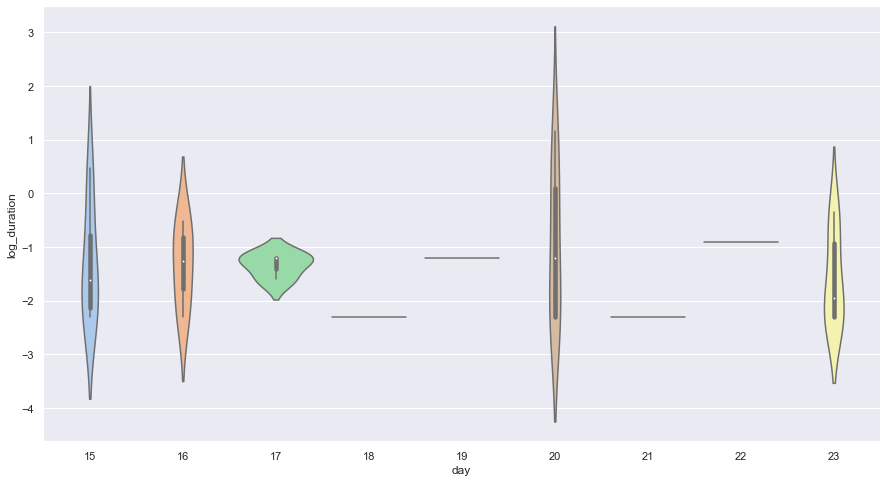

In [241]:
# example daily analysis, one week
ax = sns.violinplot(x="day", y="log_duration", data=df_c_w4[df_c_w4['object'] == obj], palette="pastel")

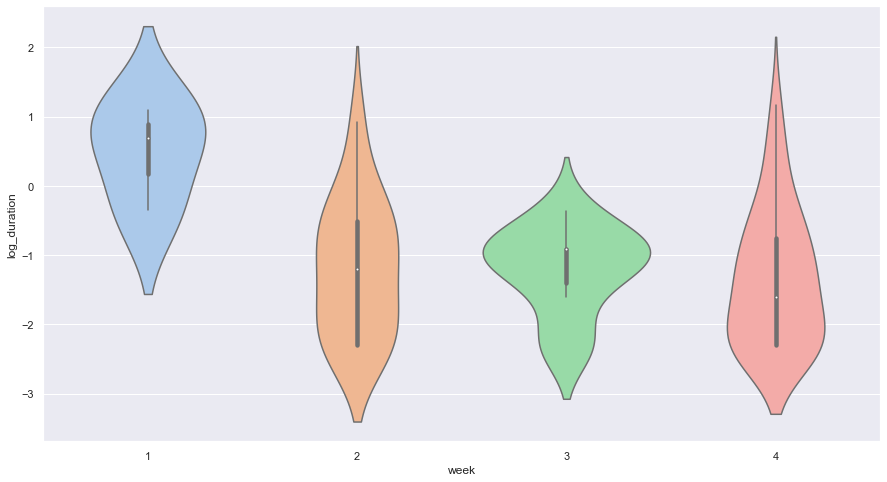

In [243]:
# example weekly analysis, entire study
ax = sns.violinplot(x="week", y="log_duration", data=df_c[df_c['object'] == obj], palette="pastel")

### One-Way ANOVA

In [60]:
df_c_summary = pd.DataFrame({
    'Week 1': df_c[(df_c['week'] == 1) & (df_c['object'] == obj)]['duration'], # df_c_w1[df_c_w1['object'] == obj]['duration'], 
    'Week 2': df_c[(df_c['week'] == 2) & (df_c['object'] == obj)]['duration'], # df_c_w2[df_c_w2['object'] == obj]['duration'], 
    'Week 3': df_c[(df_c['week'] == 3) & (df_c['object'] == obj)]['duration'], # df_c_w3[df_c_w3['object'] == obj]['duration'], 
    'Week 4': df_c[(df_c['week'] == 4) & (df_c['object'] == obj)]['duration']  # df_c_w4[df_c_w4['object'] == obj]['duration']
})

In [61]:
df_c_summary.describe()

,Week 1,Week 2,Week 3,Week 4
count,240.000000,1236.000000,629.000000,902.000000
mean,0.692799,0.656593,0.446109,0.641137
std,1.100274,1.507495,0.544783,1.089827
min,0.099592,0.099298,0.099507,0.099683
25%,0.199944,0.100486,0.100176,0.199798
50%,0.299905,0.299969,0.299438,0.399941
75%,0.600013,0.700118,0.499957,0.699993
max,6.900170,12.699752,6.000025,15.600224


In [62]:
# one-way ANOVA, check if model is significant
F, p = stats.f_oneway(
    df_c[(df_c['week'] == 1) & (df_c['object'] == obj)]['log_duration'], # df_c_w1[df_c_w1['object'] == obj]['duration'], 
    df_c[(df_c['week'] == 2) & (df_c['object'] == obj)]['log_duration'], # df_c_w2[df_c_w2['object'] == obj]['duration'], 
    df_c[(df_c['week'] == 3) & (df_c['object'] == obj)]['log_duration'], # df_c_w3[df_c_w3['object'] == obj]['duration'], 
    df_c[(df_c['week'] == 4) & (df_c['object'] == obj)]['log_duration']  # df_c_w4[df_c_w4['object'] == obj]['duration']
)

print('F-Statistic=%.3f, p=%.3f' % (F, p))

# if we see that p-value is < 0.05. 
# we can reject the null hypothesis which states that there is no difference among the different density groups

F-Statistic=9.707, p=0.000


In [63]:
from statsmodels.formula.api import ols

# one-way ANOVA, regress against each input variable to check influence over the target variable
model = ols('log_duration ~ C(week)', df_c[df_c['object'] == obj]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     9.707
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           2.26e-06
Time:                        16:41:11   Log-Likelihood:                -4238.8
No. Observations:                3007   AIC:                             8486.
Df Residuals:                    3003   BIC:                             8510.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.0203      0.064    -15.944      0.000      -1.146      -0.895
C(week)[T.2]    -0.1023      0.070     -1.463      0.144      -0.239       0.035
C(week)[T.3]    -0.2613      0.075     -3.474      0.001      -0.409      -0.114
C(week)[T.4]     0.0048      0.072      0.067      0.946      -0.136       0.146
==============================================================================
Omnibus:                      204.893   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.950
Skew:                           0.681   Prob(JB):                     2.37e-54
Kurtosis:                       3.342   Cond. No.                         8.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# check if overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 3, 3003) =  9.707, p =  0.0000


In [65]:
import statsmodels.api as sm

# create the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

# from the output, we see that the p  >0.05. 
# Therefore, we cannot reject the null hypothesis. 
# There is no difference among the different weeks

,sum_sq,df,F,PR(>F)
C(week),28.622342,3.0,9.706875,0.000002
Residual,2951.615647,3003.0,NaN,NaN


### Post Hoc

In [66]:
import statsmodels.stats.multicomp

# tukey hsd test to examine where the group differences lie
mc = statsmodels.stats.multicomp.MultiComparison(df_c['log_duration'], df_c['week'])
mc_results = mc.tukeyhsd()
print(mc_results)

# where reject = True, there is a significant difference between the groups

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0677  0.001   0.036  0.0993   True
     1      3   0.0194 0.4752 -0.0152  0.0539  False
     1      4   0.0572  0.001  0.0246  0.0899   True
     2      3  -0.0483  0.001 -0.0755 -0.0211   True
     2      4  -0.0104  0.677 -0.0352  0.0143  False
     3      4   0.0379 0.0034  0.0095  0.0662   True
----------------------------------------------------


In [67]:
# normality assumption check using shapiro wilk test
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

# if the p-value >0.05
# we can conclude that our data follows the gaussian distribution
# else, it doesn't follow the assumptions of the ANOVA model

0.9388982057571411 1.6139781719209788e-33


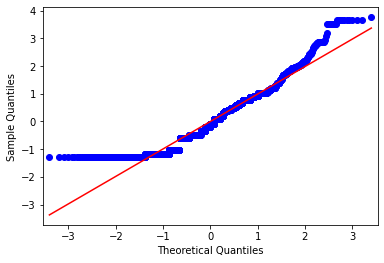

In [68]:
# using the Normal Q-Q plot to test this assumption
res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# if we see that all data points lie close to the 45-degree line
# we can conclude it follows the normal distribution

In [69]:
# homogeneity of variance assumption check

# Bartlett variance test, Method 1
wb, pb = stats.bartlett(
    df_c_w1[df_c_w1['object'] == obj]['duration'], 
    df_c_w2[df_c_w2['object'] == obj]['duration'], 
    df_c_w3[df_c_w3['object'] == obj]['duration'], 
    df_c_w4[df_c_w4['object'] == obj]['duration']
)
print('Bartlett variance test: w=%.3f, p=%.3f' % (wb, pb))

# Levene variance test, Method 2
wl, pl = stats.levene(
    df_c_w1[df_c_w1['object'] == obj]['duration'], 
    df_c_w2[df_c_w2['object'] == obj]['duration'], 
    df_c_w3[df_c_w3['object'] == obj]['duration'], 
    df_c_w4[df_c_w4['object'] == obj]['duration']
)
print('Levene variance test: w=%.3f, p=%.3f' % (wl, pl))

# if we see p > 0.05 for all weeks
# we can conclude that groups have equal variances

Bartlett variance test: w=189.354, p=0.000
Levene variance test: w=0.975, p=0.405


### Two-Way ANOVA

In [71]:
model2 = ols('log_duration ~ C(week)+ C(object)', df_c).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1017.
Date:                Fri, 18 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:41:38   Log-Likelihood:            -1.5981e+05
No. Observations:              100552   AIC:                         3.196e+05
Df Residuals:                  100544   BIC:                         3.197e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.5327      0.012    -43.691      0.000      -0.557      -0.509
C(week)[T.2]             0.0579      0.012      4.851      0.000       0.034       0.081
C(week)[T.3]             0.0082      0.013      0.628      0.530      -0.017       0.034
C(week)[T.4]             0.0596      0.012      4.836      0.000       0.035       0.084
C(object)[T.outside]    -0.3664      0.012    -31.556      0.000      -0.389      -0.344
C(object)[T.parent]     -0.6263      0.023    -27.100      0.000      -0.672      -0.581
C(object)[T.robot]      -0.2901      0.012    -23.581      0.000      -0.314      -0.266
C(object)[T.screen]      0.3444      0.010     34.178      0.000       0.325       0.364
==============================================================================
Omnibus:                     1566.665   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1644.464
Skew:                           0.305   Prob(JB):                         0.00
Kurtosis:                       3.141   Cond. No.                         8.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
print(f"Overall model F({model2.df_model: },{model2.df_resid: }) = {model2.fvalue: }, p = {model2.f_pvalue: }")

Overall model F( 7.0, 100544.0) =  1016.5174570565703, p =  0.0


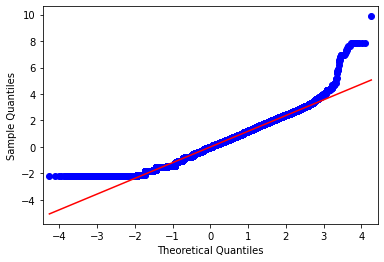

In [73]:
# create the ANOVA table
res2 = sm.stats.anova_lm(model2, typ=2)
res2

# check the Normal distribution of residuals
res = model2.resid
fig = sm.qqplot(res, line='s')
plt.show()

# from the Q-Q plot, we can see that residuals are almost normally distributed
# (although points at the extreme ends can be discounted)
# hence we conclude that it satisfies the normality assumption of the ANOVA test

In [74]:
# check the interaction of groups
formula = 'log_duration ~ C(week) *C(object)'
model = ols(formula, df_c).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     395.2
Date:                Fri, 18 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:41:45   Log-Likelihood:            -1.5963e+05
No. Observations:              100552   AIC:                         3.193e+05
Df Residuals:                  100532   BIC:                         3.195e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.3660      0.020    -18.517      0.000      -0.405      -0.327
C(week)[T.2]                         -0.1283      0.024     -5.379      0.000      -0.175      -0.082
C(week)[T.3]                         -0.2084      0.026     -7.922      0.000      -0.260      -0.157
C(week)[T.4]                         -0.1465      0.026     -5.746      0.000      -0.197      -0.097
C(object)[T.outside]                 -0.5024      0.029    -17.481      0.000      -0.559      -0.446
C(object)[T.parent]                  -0.6543      0.079     -8.291      0.000      -0.809      -0.500
C(object)[T.robot]                   -0.2989      0.035     -8.627      0.000      -0.367      -0.231
C(object)[T.screen]                  -0.0281      0.026     -1.079      0.281      -0.079       0.023
C(week)[T.2]:C(object)[T.outside]     0.1800      0.035      5.188      0.000       0.112       0.248
C(week)[T.3]:C(object)[T.outside]     0.1694      0.038      4.427      0.000       0.094       0.244
C(week)[T.4]:C(object)[T.outside]     0.1413      0.036      3.884      0.000       0.070       0.213
C(week)[T.2]:C(object)[T.parent]      0.0260      0.087      0.300      0.764      -0.144       0.196
C(week)[T.3]:C(object)[T.parent]     -0.0530      0.094     -0.566      0.571      -0.236       0.130
C(week)[T.4]:C(object)[T.parent]      0.1514      0.090      1.688      0.091      -0.024       0.327
C(week)[T.2]:C(object)[T.robot]       0.0596      0.040      1.480      0.139      -0.019       0.139
C(week)[T.3]:C(object)[T.robot]       0.0389      0.044      0.890      0.373      -0.047       0.124
C(week)[T.4]:C(object)[T.robot]      -0.0208      0.041     -0.503      0.615      -0.102       0.060
C(week)[T.2]:C(object)[T.screen]      0.3800      0.031     12.306      0.000       0.320       0.441
C(week)[T.3]:C(object)[T.screen]      0.4755      0.034     14.056      0.000       0.409       0.542
C(week)[T.4]:C(object)[T.screen]      0.4751      0.033     14.595      0.000       0.411       0.539
==============================================================================
Omnibus:                     1496.644   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1567.624
Skew:                           0.298   Prob(JB):                         0.00
Kurtosis:                       3.136   Cond. No.                         55.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
from statsmodels.stats.anova import anova_lm
aov_table = anova_lm(model, typ=2)
print(aov_table.round(4))

                        sum_sq        df          F  PR(>F)
C(week)                66.1106       3.0    15.7265     0.0
C(object)            9941.3860       4.0  1773.6589     0.0
C(week):C(object)     515.2958      12.0    30.6449     0.0
Residual           140870.8588  100532.0        NaN     NaN


In [76]:
mc = statsmodels.stats.multicomp.MultiComparison(df_c['log_duration'], df_c['object'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------------
nodetection outside  -0.3652 0.001 -0.3968 -0.3335   True
nodetection  parent  -0.6208 0.001 -0.6838 -0.5578   True
nodetection   robot   -0.286 0.001 -0.3195 -0.2525   True
nodetection  screen    0.347 0.001  0.3195  0.3744   True
    outside  parent  -0.2556 0.001 -0.3188 -0.1924   True
    outside   robot   0.0792 0.001  0.0452  0.1131   True
    outside  screen   0.7122 0.001  0.6842  0.7401   True
     parent   robot   0.3348 0.001  0.2706  0.3989   True
     parent  screen   0.9678 0.001  0.9066   1.029   True
      robot  screen    0.633 0.001   0.603   0.663   True
---------------------------------------------------------


## ANOVA on Joint Attention

In [3]:
from scipy import stats
import statsmodels.api as sm

In [4]:
PID = '1_EXP05_Full/'

In [5]:
# read from existing files
df_cr_w1 = pd.read_csv(PID + 'week_1/' + 'child-robot.csv')
df_cp_w1 = pd.read_csv(PID + 'week_1/' + 'child-parent.csv')
df_pr_w1 = pd.read_csv(PID + 'week_1/' + 'parent-robot.csv')

df_cr_w2 = pd.read_csv(PID + 'week_2/' + 'child-robot.csv')
df_cp_w2 = pd.read_csv(PID + 'week_2/' + 'child-parent.csv')
df_pr_w2 = pd.read_csv(PID + 'week_2/' + 'parent-robot.csv')

df_cr_w3 = pd.read_csv(PID + 'week_3/' + 'child-robot.csv')
df_cp_w3 = pd.read_csv(PID + 'week_3/' + 'child-parent.csv')
df_pr_w3 = pd.read_csv(PID + 'week_3/' + 'parent-robot.csv')

df_cr_w4 = pd.read_csv(PID + 'week_4/' + 'child-robot.csv')
df_cp_w4 = pd.read_csv(PID + 'week_4/' + 'child-parent.csv')
df_pr_w4 = pd.read_csv(PID + 'week_4/' + 'parent-robot.csv')

In [6]:
# remove outlier lags based on stable behavior throughout the week
df_cr_w1 = df_cr_w1[(np.abs(stats.zscore(df_cr_w1['lag'])) < 3)].reset_index()
df_cp_w1 = df_cp_w1[(np.abs(stats.zscore(df_cp_w1['lag'])) < 3)].reset_index()
df_pr_w1 = df_pr_w1[(np.abs(stats.zscore(df_pr_w1['lag'])) < 3)].reset_index()

df_cr_w2 = df_cr_w2[(np.abs(stats.zscore(df_cr_w2['lag'])) < 3)].reset_index()
df_cp_w2 = df_cp_w2[(np.abs(stats.zscore(df_cp_w2['lag'])) < 3)].reset_index()
df_pr_w2 = df_pr_w2[(np.abs(stats.zscore(df_pr_w2['lag'])) < 3)].reset_index()

df_cr_w3 = df_cr_w3[(np.abs(stats.zscore(df_cr_w3['lag'])) < 3)].reset_index()
df_cp_w3 = df_cp_w3[(np.abs(stats.zscore(df_cp_w3['lag'])) < 3)].reset_index()
df_pr_w3 = df_pr_w3[(np.abs(stats.zscore(df_pr_w3['lag'])) < 3)].reset_index()

df_cr_w4 = df_cr_w4[(np.abs(stats.zscore(df_cr_w4['lag'])) < 3)].reset_index()
df_cp_w4 = df_cp_w4[(np.abs(stats.zscore(df_cp_w4['lag'])) < 3)].reset_index()
df_pr_w4 = df_pr_w4[(np.abs(stats.zscore(df_pr_w4['lag'])) < 3)].reset_index()

In [5]:
def unix_to_datetime(ts):
    return datetime.utcfromtimestamp(ts)

def get_unique_days(df_column):
    realtime = df_column.apply(lambda x: unix_to_datetime(x))
    days = np.array(realtime.apply(lambda x: x.day))
    return days, np.unique(days)

def get_day_into_study(days, prev_days = 0):
    adj = list(range(0, len(days)))
    res = [x + prev_days for x in adj]
    return res

def search(l, n):
    for i in range(len(l)):
        if l[i] == n:
            return i
    return -1

def adjust_day(uniq, n, blind = 0):
    haystack = uniq[blind:]
    idx = search(haystack, n)
    return idx + blind

In [8]:
_, unique_days_w1 = get_unique_days(df_cr_w1['start'])
_, unique_days_w2 = get_unique_days(df_cr_w2['start'])
_, unique_days_w3 = get_unique_days(df_cr_w3['start'])
_, unique_days_w4 = get_unique_days(df_cr_w4['start'])

unique_days = np.concatenate((unique_days_w1, unique_days_w2, unique_days_w3, unique_days_w4), axis = 0)
print(unique_days)

[ 7 10 11 14 16 17 18 20 21 22 23 25 27 28  2  3  4  5  6  7  8 29 30 31]


In [9]:
df_cr_w1['day_study'] = df_cr_w1['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day))
df_cr_w2['day_study'] = df_cr_w2['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)))
df_cr_w3['day_study'] = df_cr_w3['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)))
df_cr_w4['day_study'] = df_cr_w4['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)+len(unique_days_w3)))

In [93]:
# frames = [df_cr_w1, df_cr_w2, df_cr_w3, df_cr_w4]
# df_cr = pd.concat(frames)
# df_cr = df_cr.iloc[:, 1:]

In [94]:
df_cr

,object,duration,start,initiator,lag,day_study,week_study
0,contact,0.999396,1.499458e+09,robot,13.697562,0,1
1,contact,19.099964,1.499458e+09,robot,14.796889,0,1
2,contact,1.499971,1.499458e+09,robot,0.904794,0,1
3,contact,2.199933,1.499458e+09,robot,2.504795,0,1
4,contact,0.199958,1.499458e+09,robot,4.804777,0,1
...,...,...,...,...,...,...,...
6358,contact,0.000000,1.502151e+09,robot,10.845541,20,4
6359,contact,0.199831,1.502151e+09,robot,10.945595,20,4
6360,contact,0.200178,1.502151e+09,robot,11.245524,20,4
6361,contact,4.099981,1.502151e+09,robot,11.545519,20,4


In [ ]:
# across control and experimental
resumption_lag_y = df_x['te_p_resumption'] - df_x['a_p_resumption']
resumption_lag_x = df_x.drop(columns=['te_p_resumption', 'a_p_resumption'])

In [ ]:
model = sm.OLS(resumption_lag_y, resumption_lag_x)
results = model.fit()
print(results.summary())